1. Track ID: Cb-ord-A2-ff-1c-R100d

- Cb: Instrument abbreviation (Contrabass)
- ord: Technique abbreviation (ordinario, normal or standard playing technique)
- A2: Pitch 
- ff: Dynamics (fortissimo, loud)
- 1c: The string which is being bowed (On the first string)
- R100d: Resampled by decreasing pitch by a semitone, i.e. 100 cents (R100d)


In [1]:
import librosa
import tensorflow as tf
import mirdata

# Initialize tinysol dat
tinysol_dataset = mirdata.initialize("tinysol")
tinysol_dataset.download()
# Load tinysol metadata
tinysol_metadata = tinysol_dataset._metadata

INFO: Downloading ['audio', 'annotations'] to /Users/yian/mir_datasets/tinysol
INFO: [audio] downloading TinySOL.tar.gz
INFO: /Users/yian/mir_datasets/tinysol/audio/TinySOL.tar.gz already exists and will not be downloaded. Rerun with force_overwrite=True to delete this file and force the download.
INFO: [annotations] downloading TinySOL_metadata.csv
INFO: /Users/yian/mir_datasets/tinysol/annotation/TinySOL_metadata.csv already exists and will not be downloaded. Rerun with force_overwrite=True to delete this file and force the download.


2.
-Spectrogram: Visualize the spectrum of frequencies in a sound signal as they vary with time.
-Mel-Spectrogram: Based on the following images, the Mel-Spectrogram emphasizes lower frequencies more than Spectrogram, which is more aligned with human hearing.
-MFCC: Derived from the log mel-spectrogram, capturing the envelope of the spectrum.

In [2]:
y, sr = tinysol_dataset.track("BTb-ord-F#1-pp-N-N").audio

/var/folders/bq/9bl_kyf57_l8skp92spbmb400000gn/T/ipykernel_37158/3173994840.py:6: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  librosa.display.specshow(librosa.amplitude_to_db(librosa.stft(y), ref=np.max), sr=sr, x_axis='time', y_axis='log')


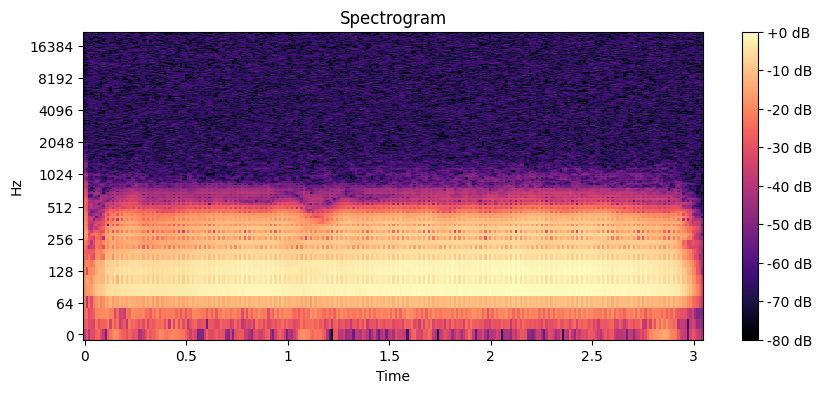

In [3]:
import numpy as np
import librosa.display
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.amplitude_to_db(librosa.stft(y), ref=np.max), sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.show()

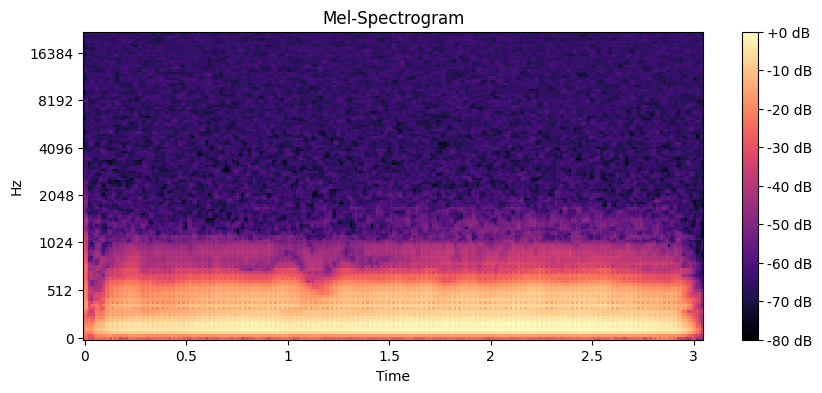

In [4]:
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)

plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(S, ref=np.max), sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-Spectrogram')
plt.show()

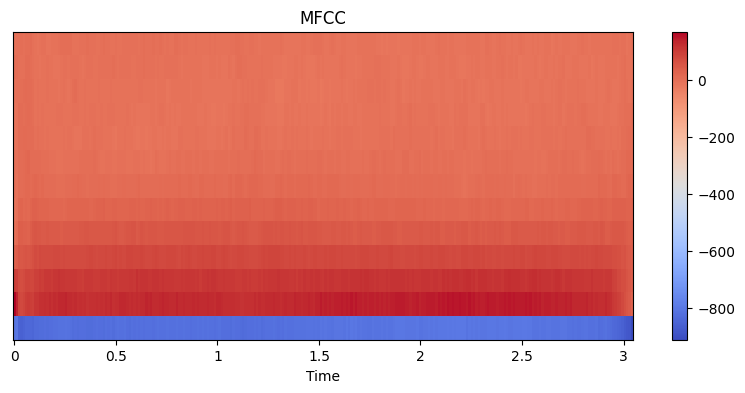

In [5]:
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, sr=sr, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.show()

3. Instrument classification:

In summary, both the SVM and MLP models perform well comparing to Decision tree, with both higher than 90% accuracy . Based the the confusion matrix results below, MLP seems to strike a good balance between classifying different instruments correctly and maintaining fewer misclassifications. 

In [6]:
import numpy as np
# Create empty lists to store MFCC features and labels
mfccs_list = []
instrument_list = []
pitch_list = []

i=0
# Iterate through all the tracks in the dataset
for track_id in tinysol_dataset.track_ids:
  i=i+1
  # Load a track by its ID
  track = tinysol_dataset.track(track_id)

  # Print some track information
  print("Track ID:", track.track_id)
  print("Instrument name:", track.instrument_full)
  print("Pitch class:", track.pitch)
  print("Music count:",i)
  #print("Dynamics:", track.dynamics)

  # Load and play the audio file of the track
  audio, sr = track.audio
  #track.play_audio()
  feat = np.mean(librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40).T, axis=0)

  # Append the MFCC features and labels to the lists
  mfccs_list.append(feat)
  instrument_list.append(track.instrument_full)
  pitch_list.append(track.pitch)
  

print("total:",i)






Track ID: BTb-ord-F#1-pp-N-N
Instrument name: Bass Tuba
Pitch class: F#1
Music count: 1
Track ID: BTb-ord-G1-pp-N-R100u
Instrument name: Bass Tuba
Pitch class: G1
Music count: 2
Track ID: BTb-ord-G#1-pp-N-T16u
Instrument name: Bass Tuba
Pitch class: G#1
Music count: 3
Track ID: BTb-ord-A1-pp-N-T23d
Instrument name: Bass Tuba
Pitch class: A1
Music count: 4
Track ID: BTb-ord-A#1-pp-N-N
Instrument name: Bass Tuba
Pitch class: A#1
Music count: 5
Track ID: BTb-ord-B1-pp-N-N
Instrument name: Bass Tuba
Pitch class: B1
Music count: 6
Track ID: BTb-ord-C2-pp-N-T13d
Instrument name: Bass Tuba
Pitch class: C2
Music count: 7
Track ID: BTb-ord-C#2-pp-N-N
Instrument name: Bass Tuba
Pitch class: C#2
Music count: 8
Track ID: BTb-ord-D2-pp-N-T18u
Instrument name: Bass Tuba
Pitch class: D2
Music count: 9
Track ID: BTb-ord-D#2-pp-N-T11u
Instrument name: Bass Tuba
Pitch class: D#2
Music count: 10
Track ID: BTb-ord-E2-pp-N-T25u
Instrument name: Bass Tuba
Pitch class: E2
Music count: 11
Track ID: BTb-ord-F2

In [7]:
# Convert the lists to numpy arrays for tensorflow compatibility[^2^][2] [^3^][3]
mfccs_array = np.array(mfccs_list)
instrument_array = np.array(instrument_list)
pitch_array = np.array(pitch_list)

In [8]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
instrument_array = le.fit_transform(instrument_array)
instr_classes = le.classes_
print(instr_classes)
pitch_array = le.fit_transform(pitch_array)
pitch_classes = le.classes_
print(pitch_classes)

['Accordion' 'Alto Saxophone' 'Bass Tuba' 'Bassoon' 'Cello'
 'Clarinet in Bb' 'Contrabass' 'Flute' 'French Horn' 'Oboe' 'Trombone'
 'Trumpet in C' 'Viola' 'Violin']
['A#1' 'A#2' 'A#3' 'A#4' 'A#5' 'A#6' 'A#7' 'A1' 'A2' 'A3' 'A4' 'A5' 'A6'
 'A7' 'B1' 'B2' 'B3' 'B4' 'B5' 'B6' 'B7' 'C#2' 'C#3' 'C#4' 'C#5' 'C#6'
 'C#7' 'C#8' 'C2' 'C3' 'C4' 'C5' 'C6' 'C7' 'C8' 'D#2' 'D#3' 'D#4' 'D#5'
 'D#6' 'D#7' 'D2' 'D3' 'D4' 'D5' 'D6' 'D7' 'E1' 'E2' 'E3' 'E4' 'E5' 'E6'
 'E7' 'F#1' 'F#2' 'F#3' 'F#4' 'F#5' 'F#6' 'F#7' 'F1' 'F2' 'F3' 'F4' 'F5'
 'F6' 'F7' 'G#1' 'G#2' 'G#3' 'G#4' 'G#5' 'G#6' 'G#7' 'G1' 'G2' 'G3' 'G4'
 'G5' 'G6' 'G7']


In [9]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, ConfusionMatrixDisplay

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train_instrument, y_test_instrument, y_train_pitch, y_test_pitch = train_test_split(
    mfccs_array, instrument_array, pitch_array,test_size=0.2, random_state=23) # DON'T Modify Random_state!


In [11]:
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, figsize=(6, 6)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    fig.colorbar(im)
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks, classes, rotation=90)
    ax.set_yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    plt.show()

3.(a) SVM instrument classification performance:

1. SVM demonstrates a high degree of diagonal concentration, indicating that it has high accuracy across most instrument classes.
2. Based on the confusion matrix below, The Bass Tuba, Bassoon, Oboe, Trombone and Trumpet in C are  well-classified, maybe because their sound are unique.
3. Many intruments are easily being missclassified to Accordion, maybe because there is more an imbalance with the dataset, with more Accordion data in it.

In [12]:
# Import scikit-learn library for SVM model and K-fold cross-validation
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report
print("SVM:")
# Create a model for Intstrument Classification
svm_model = SVC(kernel='linear', random_state=42)

# Perform K-fold cross-validation
kfold = KFold(n_splits=6)
for train_index, val_index in kfold.split(X_train):
  X_train_kfold, X_val_kfold = X_train[train_index], X_train[val_index]
  y_train_kfold_instrument, y_val_kfold_instrument = y_train_instrument[train_index], y_train_instrument[val_index]
  # print(X_train_kfold) and print(y_train_kfold_instrument)
  svm_model.fit(X_train_kfold, y_train_kfold_instrument)
  print(" Validation score:", svm_model.score(X_val_kfold,y_val_kfold_instrument))

print("Test score:", svm_model.score(X_test,y_test_instrument))

SVM:
 Validation score: 0.9408740359897172
 Validation score: 0.9357326478149101
 Validation score: 0.9201030927835051
 Validation score: 0.9252577319587629
 Validation score: 0.9381443298969072
 Validation score: 0.9355670103092784
Test score: 0.9485420240137221


Confusion matrix


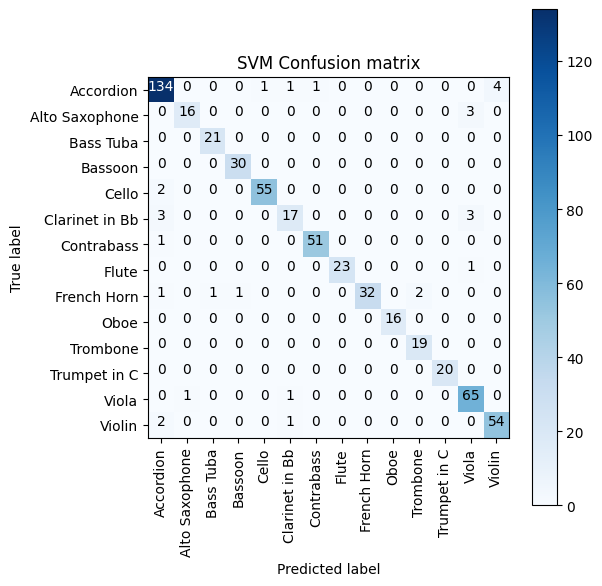

ACC =  0.949
precision =  0.949
recall =  0.949


In [13]:
y_pred_instr = svm_model.predict(X_test)
accuracy = accuracy_score(y_test_instrument, y_pred_instr)
recall = recall_score(y_test_instrument, y_pred_instr, average='micro') #can try other ave method
precision = precision_score(y_test_instrument, y_pred_instr, average='micro')
cm = confusion_matrix(y_test_instrument, y_pred_instr)
plot_confusion_matrix(cm , instr_classes, title="SVM Confusion matrix")
print('ACC = ',  round(accuracy,3))
print('precision = ', round(precision,3))
print('recall = ', round(recall, 3))

In [14]:
# Import scikit-learn library for SVM model and K-fold cross-validation
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report
print("RBF SVM:")
# Create a model for Intstrument Classification
svm_model = SVC(kernel='rbf', random_state=42)

# Perform K-fold cross-validation
kfold = KFold(n_splits=6)
for train_index, val_index in kfold.split(X_train):
  X_train_kfold, X_val_kfold = X_train[train_index], X_train[val_index]
  y_train_kfold_instrument, y_val_kfold_instrument = y_train_instrument[train_index], y_train_instrument[val_index]
  # print(X_train_kfold) and print(y_train_kfold_instrument)
  svm_model.fit(X_train_kfold, y_train_kfold_instrument)
  print(" Validation score:", svm_model.score(X_val_kfold,y_val_kfold_instrument))

print("Test score:", svm_model.score(X_test,y_test_instrument))

RBF SVM:


 Validation score: 0.6555269922879178
 Validation score: 0.6298200514138818
 Validation score: 0.634020618556701
 Validation score: 0.6752577319587629
 Validation score: 0.6108247422680413
 Validation score: 0.6262886597938144
Test score: 0.6518010291595198


3.(b) Decision Tree instrument classification performance:

1. The Decision Tree has a less concentrated diagonal, implying more misclassifications across the board compared to the SVM and MLP.
2. Based on the comfusion matrix below, the Accordion class has a notable number of misclassifications.
3. Based on the comfusion matrix below, the Accordion and Violin class are easily being misclassifications.

In [15]:
# Import scikit-learn library for SVM model and K-fold cross-validation
print("Decision tree:")
# Create a model for Intstrument Classification
decisiontree_model = DecisionTreeClassifier(random_state=42)

# Perform K-fold cross-validation
kfold = KFold(n_splits=6)
for train_index, val_index in kfold.split(X_train):
  X_train_kfold, X_val_kfold = X_train[train_index], X_train[val_index]
  y_train_kfold_instrument, y_val_kfold_instrument = y_train_instrument[train_index], y_train_instrument[val_index]

  decisiontree_model.fit(X_train_kfold, y_train_kfold_instrument)

  print(" Validation score:", decisiontree_model.score(X_val_kfold,y_val_kfold_instrument))

print("Test score:", decisiontree_model.score(X_test,y_test_instrument))

Decision tree:
 Validation score: 0.794344473007712
 Validation score: 0.7455012853470437
 Validation score: 0.7835051546391752
 Validation score: 0.8247422680412371
 Validation score: 0.788659793814433
 Validation score: 0.7422680412371134
Test score: 0.8010291595197255


Confusion matrix


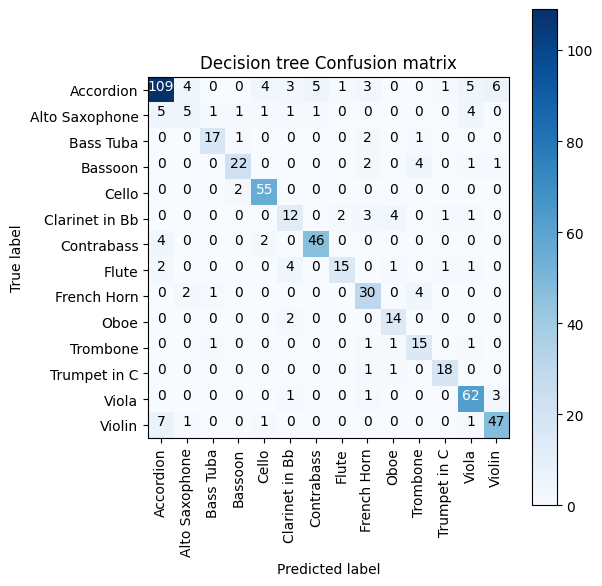

ACC =  0.801
precision =  0.801
recall =  0.801


In [16]:
y_pred_instr = decisiontree_model.predict(X_test)
accuracy = accuracy_score(y_test_instrument, y_pred_instr)
recall = recall_score(y_test_instrument, y_pred_instr, average='micro') 
precision = precision_score(y_test_instrument, y_pred_instr, average='micro')
cm = confusion_matrix(y_test_instrument, y_pred_instr)
plot_confusion_matrix(cm , instr_classes, title="Decision tree Confusion matrix")
print('ACC = ',  round(accuracy,3))
print('precision = ', round(precision,3))
print('recall = ', round(recall, 3))

3.(c) MLP instrument classification performance:

The MLP shows a highly concentrated diagonal, suggesting a strong classification performance similar to the SVM.
Based on the confusion matrix below, the Accordion, Contrabass, Viola and Violin classes have very high correct classification rates.



In [17]:
print("MLP:")
# Create a model for Intstrument Classification
MLP_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)

# Perform K-fold cross-validation
kfold = KFold(n_splits=6)
for train_index, val_index in kfold.split(X_train):
  X_train_kfold, X_val_kfold = X_train[train_index], X_train[val_index]
  y_train_kfold_instrument, y_val_kfold_instrument = y_train_instrument[train_index], y_train_instrument[val_index]

  MLP_model.fit(X_train_kfold, y_train_kfold_instrument)
  print(" Validation score:", MLP_model.score(X_val_kfold,y_val_kfold_instrument))

print("Test score:", MLP_model.score(X_test,y_test_instrument))

MLP:
 Validation score: 0.9254498714652957
 Validation score: 0.9511568123393316
 Validation score: 0.9201030927835051
 Validation score: 0.9536082474226805
 Validation score: 0.9458762886597938
 Validation score: 0.9381443298969072
Test score: 0.9519725557461407


Confusion matrix


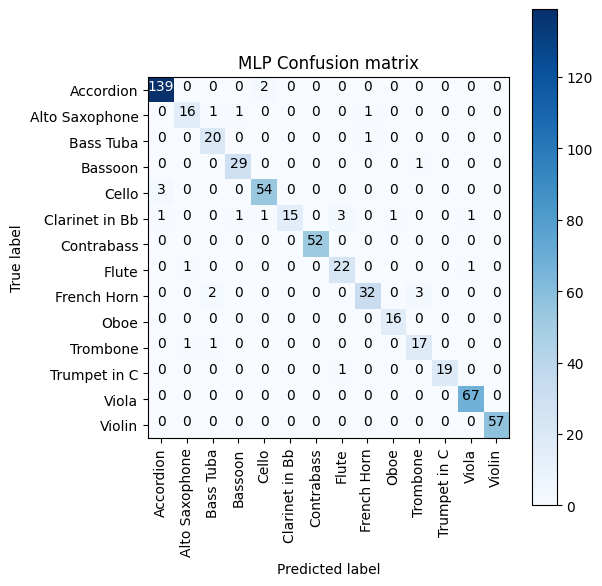

ACC =  0.952
precision =  0.952
recall =  0.952


In [18]:
y_pred_instr = MLP_model.predict(X_test)
accuracy = accuracy_score(y_test_instrument, y_pred_instr)
recall = recall_score(y_test_instrument, y_pred_instr, average='micro') #can try other ave method
precision = precision_score(y_test_instrument, y_pred_instr, average='micro')
cm = confusion_matrix(y_test_instrument, y_pred_instr)
plot_confusion_matrix(cm , instr_classes, title="MLP Confusion matrix")
print('ACC = ',  round(accuracy,3))
print('precision = ', round(precision,3))
print('recall = ', round(recall, 3))

4. Pitch classification:

Based on the following results, the SVM model appears to be the best performing of the three for this pitch classification task. It has consistent validation and test scores.

In contrast, the Decision Tree performs the worst among the three, with the lowest test score and greater variability in validation scores. 

The MLP falls between the two, with good performance but not quite reaching the level of the SVM. 

For overall results of pitch classification performance comparing to instrument classification performance, it seems that the MFCC spetogram is better used for instrument classification, since it can capture timbral characteristics and the broad phonetic features of different audio signal.

4. 
(a) SVM pitch classification performance:

1. The SVM has shown consistent and high validation scores around 0.82 to 0.84, indicating good generalization on the validation sets, and its test score of 0.851 suggests that the SVM has performed well on unseen data, maintaining accuracy close to its validation scores.
2. The SVM confusion matrix shows a relatively dense diagonal, indicating a high number of correct predictions across different pitch classes.

In [19]:
print("SVM train")
# Create a model for Pitch Classification
svm_model_pitch = SVC(kernel='linear', random_state=42)
# Perform K-fold cross-validation
kfold = KFold(n_splits=6)
for train_index, val_index in kfold.split(X_train):
  # Get the train and validation subsets
  X_train_kfold, X_val_kfold = X_train[train_index], X_train[val_index]
  y_train_kfold_pitch, y_val_kfold_pitch = y_train_pitch[train_index], y_train_pitch[val_index]
  svm_model_pitch.fit(X_train_kfold, y_train_kfold_pitch)
  print(" Validation score:", svm_model_pitch.score(X_val_kfold,y_val_kfold_pitch))

print("Test score:", svm_model_pitch.score(X_test,y_test_pitch))

SVM train
 Validation score: 0.8226221079691517
 Validation score: 0.8329048843187661
 Validation score: 0.8273195876288659
 Validation score: 0.845360824742268
 Validation score: 0.845360824742268
 Validation score: 0.8350515463917526
Test score: 0.8507718696397941


In [20]:
print("SVM evaluation")
y_pred_pitch = svm_model_pitch.predict(X_test)

accuracy = accuracy_score(y_test_pitch, y_pred_pitch)
recall = recall_score(y_test_pitch, y_pred_pitch, average='micro') #can try other ave method
precision = precision_score(y_test_pitch, y_pred_pitch, average='micro')

print('ACC = ',  round(accuracy,3))
print('precision = ', precision)
print('recall = ', recall)

SVM evaluation
ACC =  0.851
precision =  0.8507718696397941
recall =  0.8507718696397941


Confusion matrix


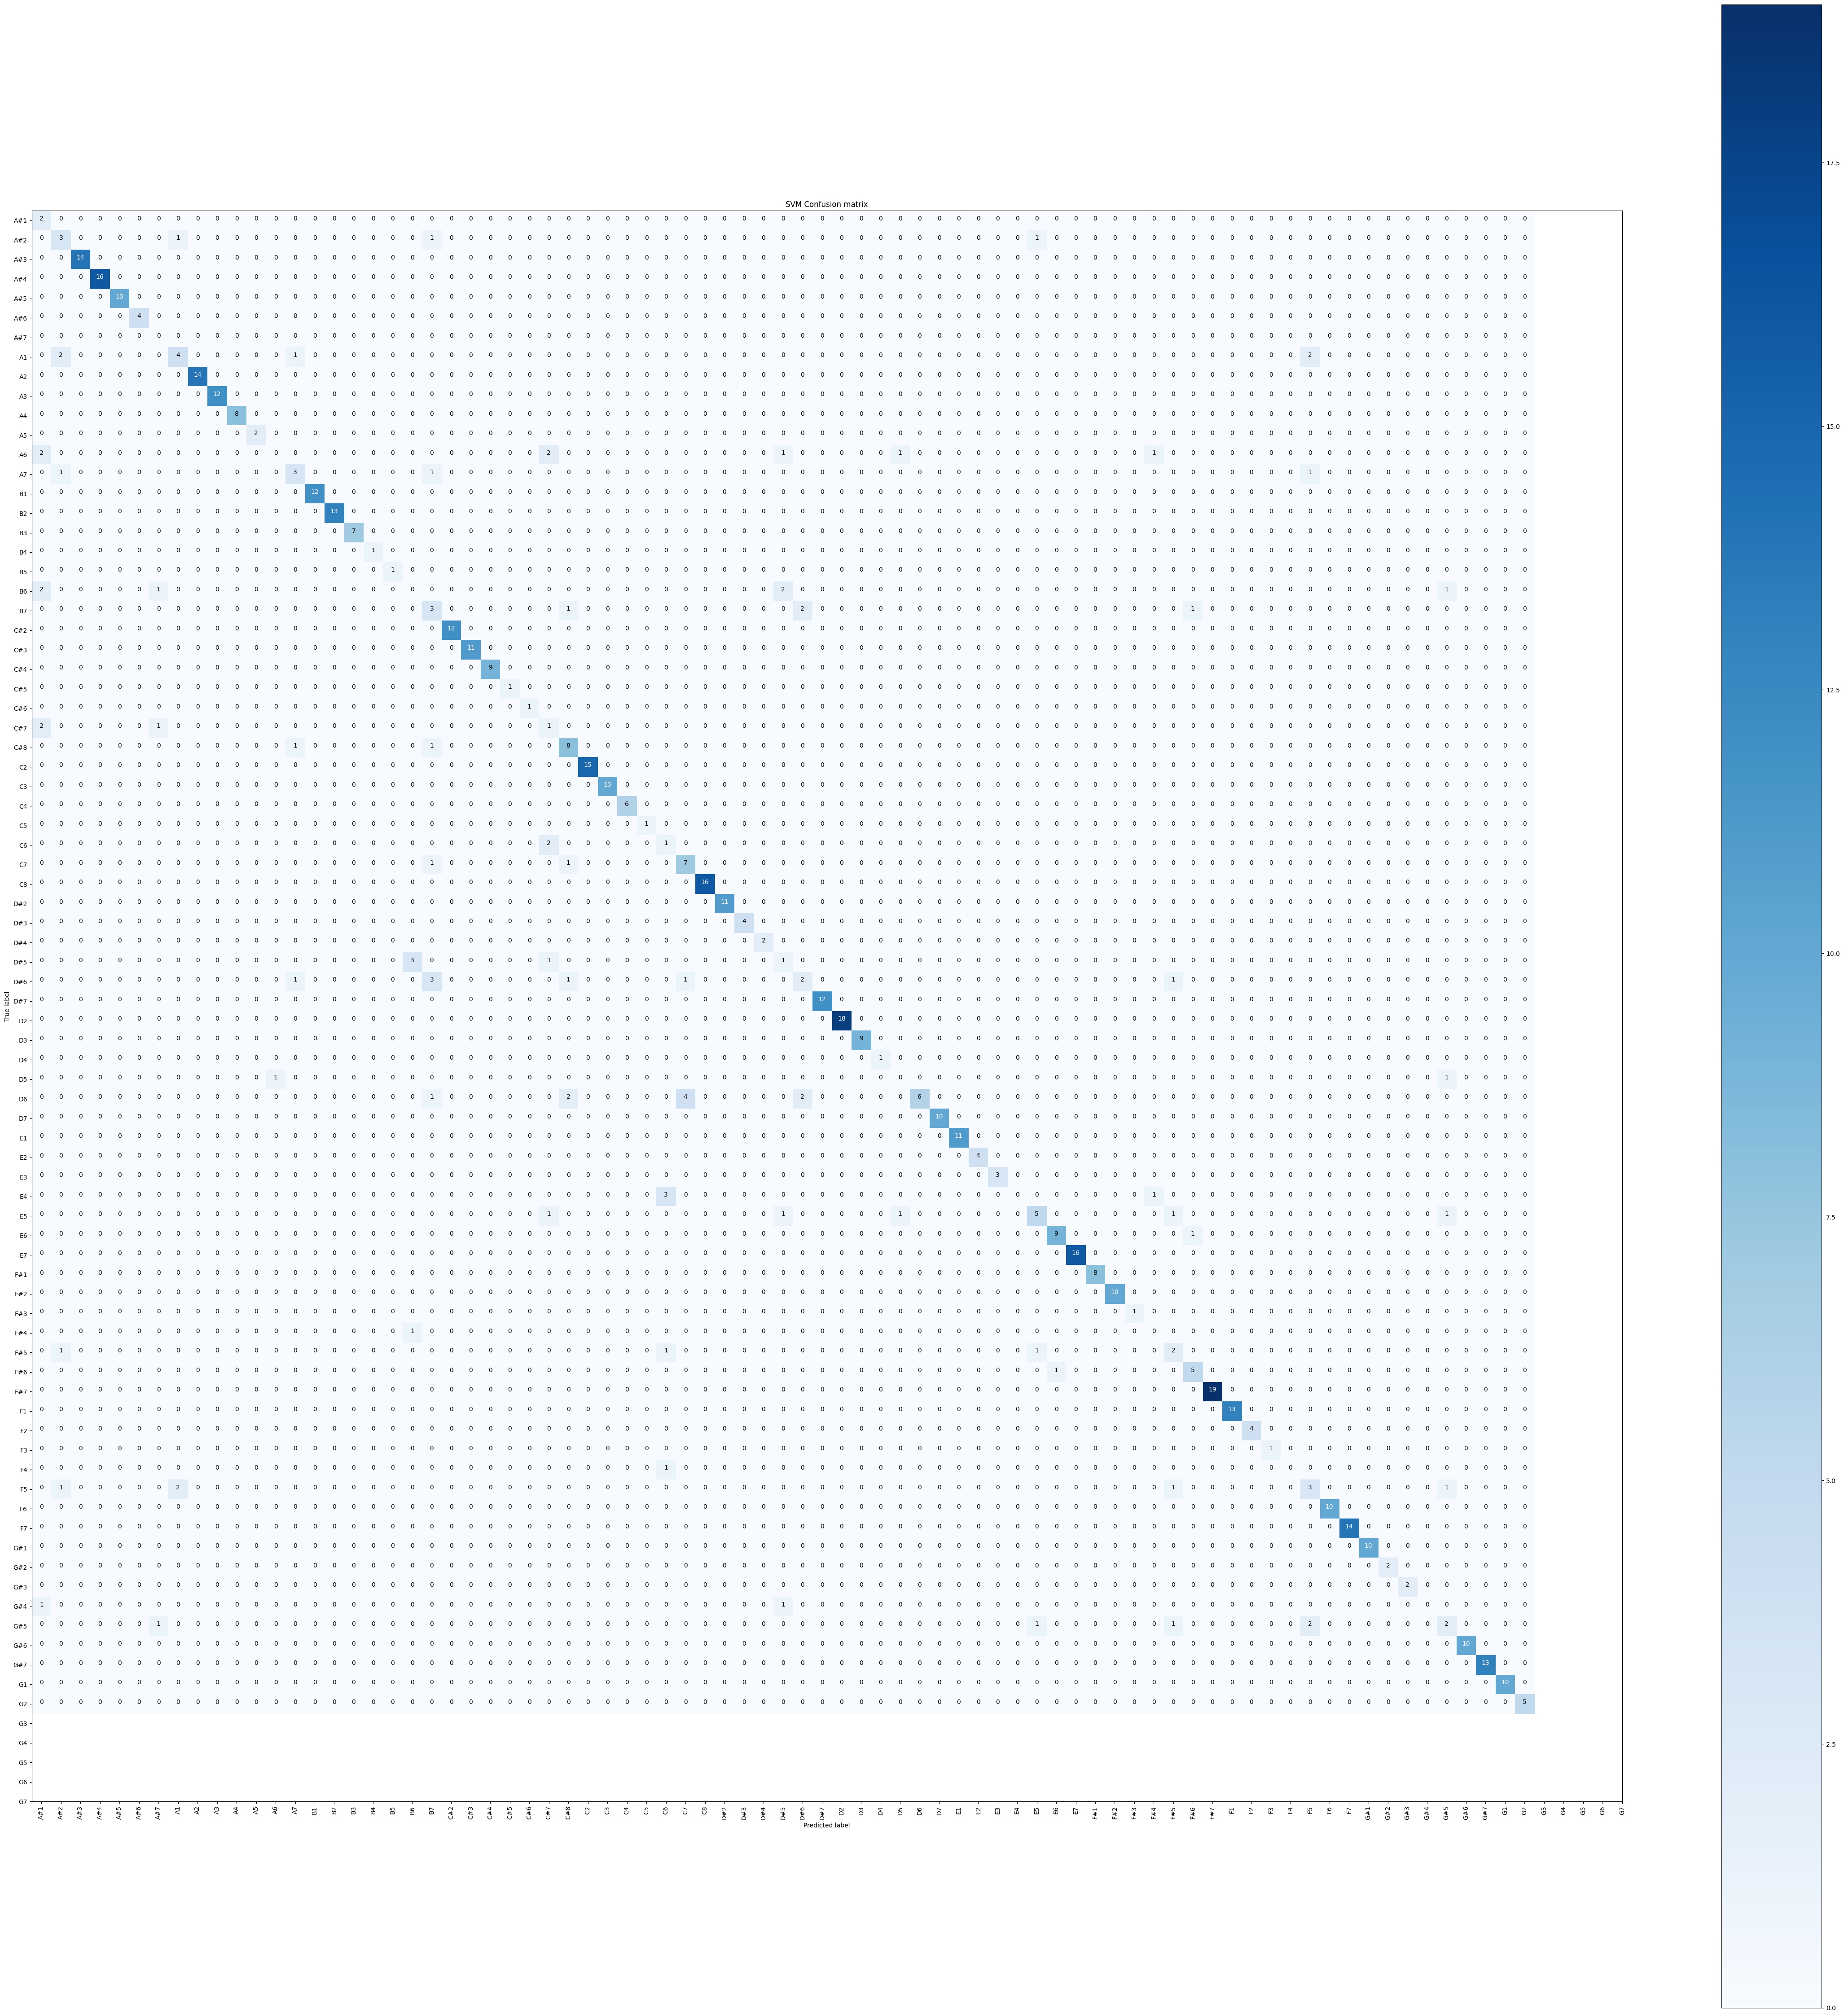

In [21]:
cm = confusion_matrix(y_test_pitch, y_pred_pitch)
plot_confusion_matrix(cm , pitch_classes, title="SVM Confusion matrix",figsize=(45,45))


4.
(b) Decision Tree pitch classification performance:

1. Decision tree validation scores are noticeably lower and more varied, ranging from about 0.63 to 0.71. This suggests that the decision tree may be more sensitive to the specific splits of the data and may not generalize as well as SVM.

2. The test score of 0.736 shows that the decision tree's performance dropped when confronted with the test set.

3. The performance across different pitch classes seems to be less consistent compared to the SVM, with some classes having higher misclassification rates.

In [22]:
print("Decision tree train:")
# Create a model for Pitch Classification
dt_model_pitch = DecisionTreeClassifier(random_state=42)
# Perform K-fold cross-validation
kfold = KFold(n_splits=6)
for train_index, val_index in kfold.split(X_train):
  # Get the train and validation subsets
  X_train_kfold, X_val_kfold = X_train[train_index], X_train[val_index]
  y_train_kfold_pitch, y_val_kfold_pitch = y_train_pitch[train_index], y_train_pitch[val_index]
  dt_model_pitch.fit(X_train_kfold, y_train_kfold_pitch)

  print(" Validation score:", dt_model_pitch.score(X_val_kfold,y_val_kfold_pitch))

print("Test score:", dt_model_pitch.score(X_test,y_test_pitch))

Decision tree train:
 Validation score: 0.6915167095115681
 Validation score: 0.7043701799485861
 Validation score: 0.6314432989690721
 Validation score: 0.7087628865979382
 Validation score: 0.6804123711340206
 Validation score: 0.6958762886597938
Test score: 0.7358490566037735


In [23]:
print("Decision tree evaluation:")
y_pred_pitch = dt_model_pitch.predict(X_test)

accuracy = accuracy_score(y_test_pitch, y_pred_pitch)
recall = recall_score(y_test_pitch, y_pred_pitch, average='micro') #can try other ave method
precision = precision_score(y_test_pitch, y_pred_pitch, average='micro')

print('ACC = ',  round(accuracy,3))
print('precision = ', precision)
print('recall = ', recall)

Decision tree evaluation:
ACC =  0.736
precision =  0.7358490566037735
recall =  0.7358490566037735


Confusion matrix


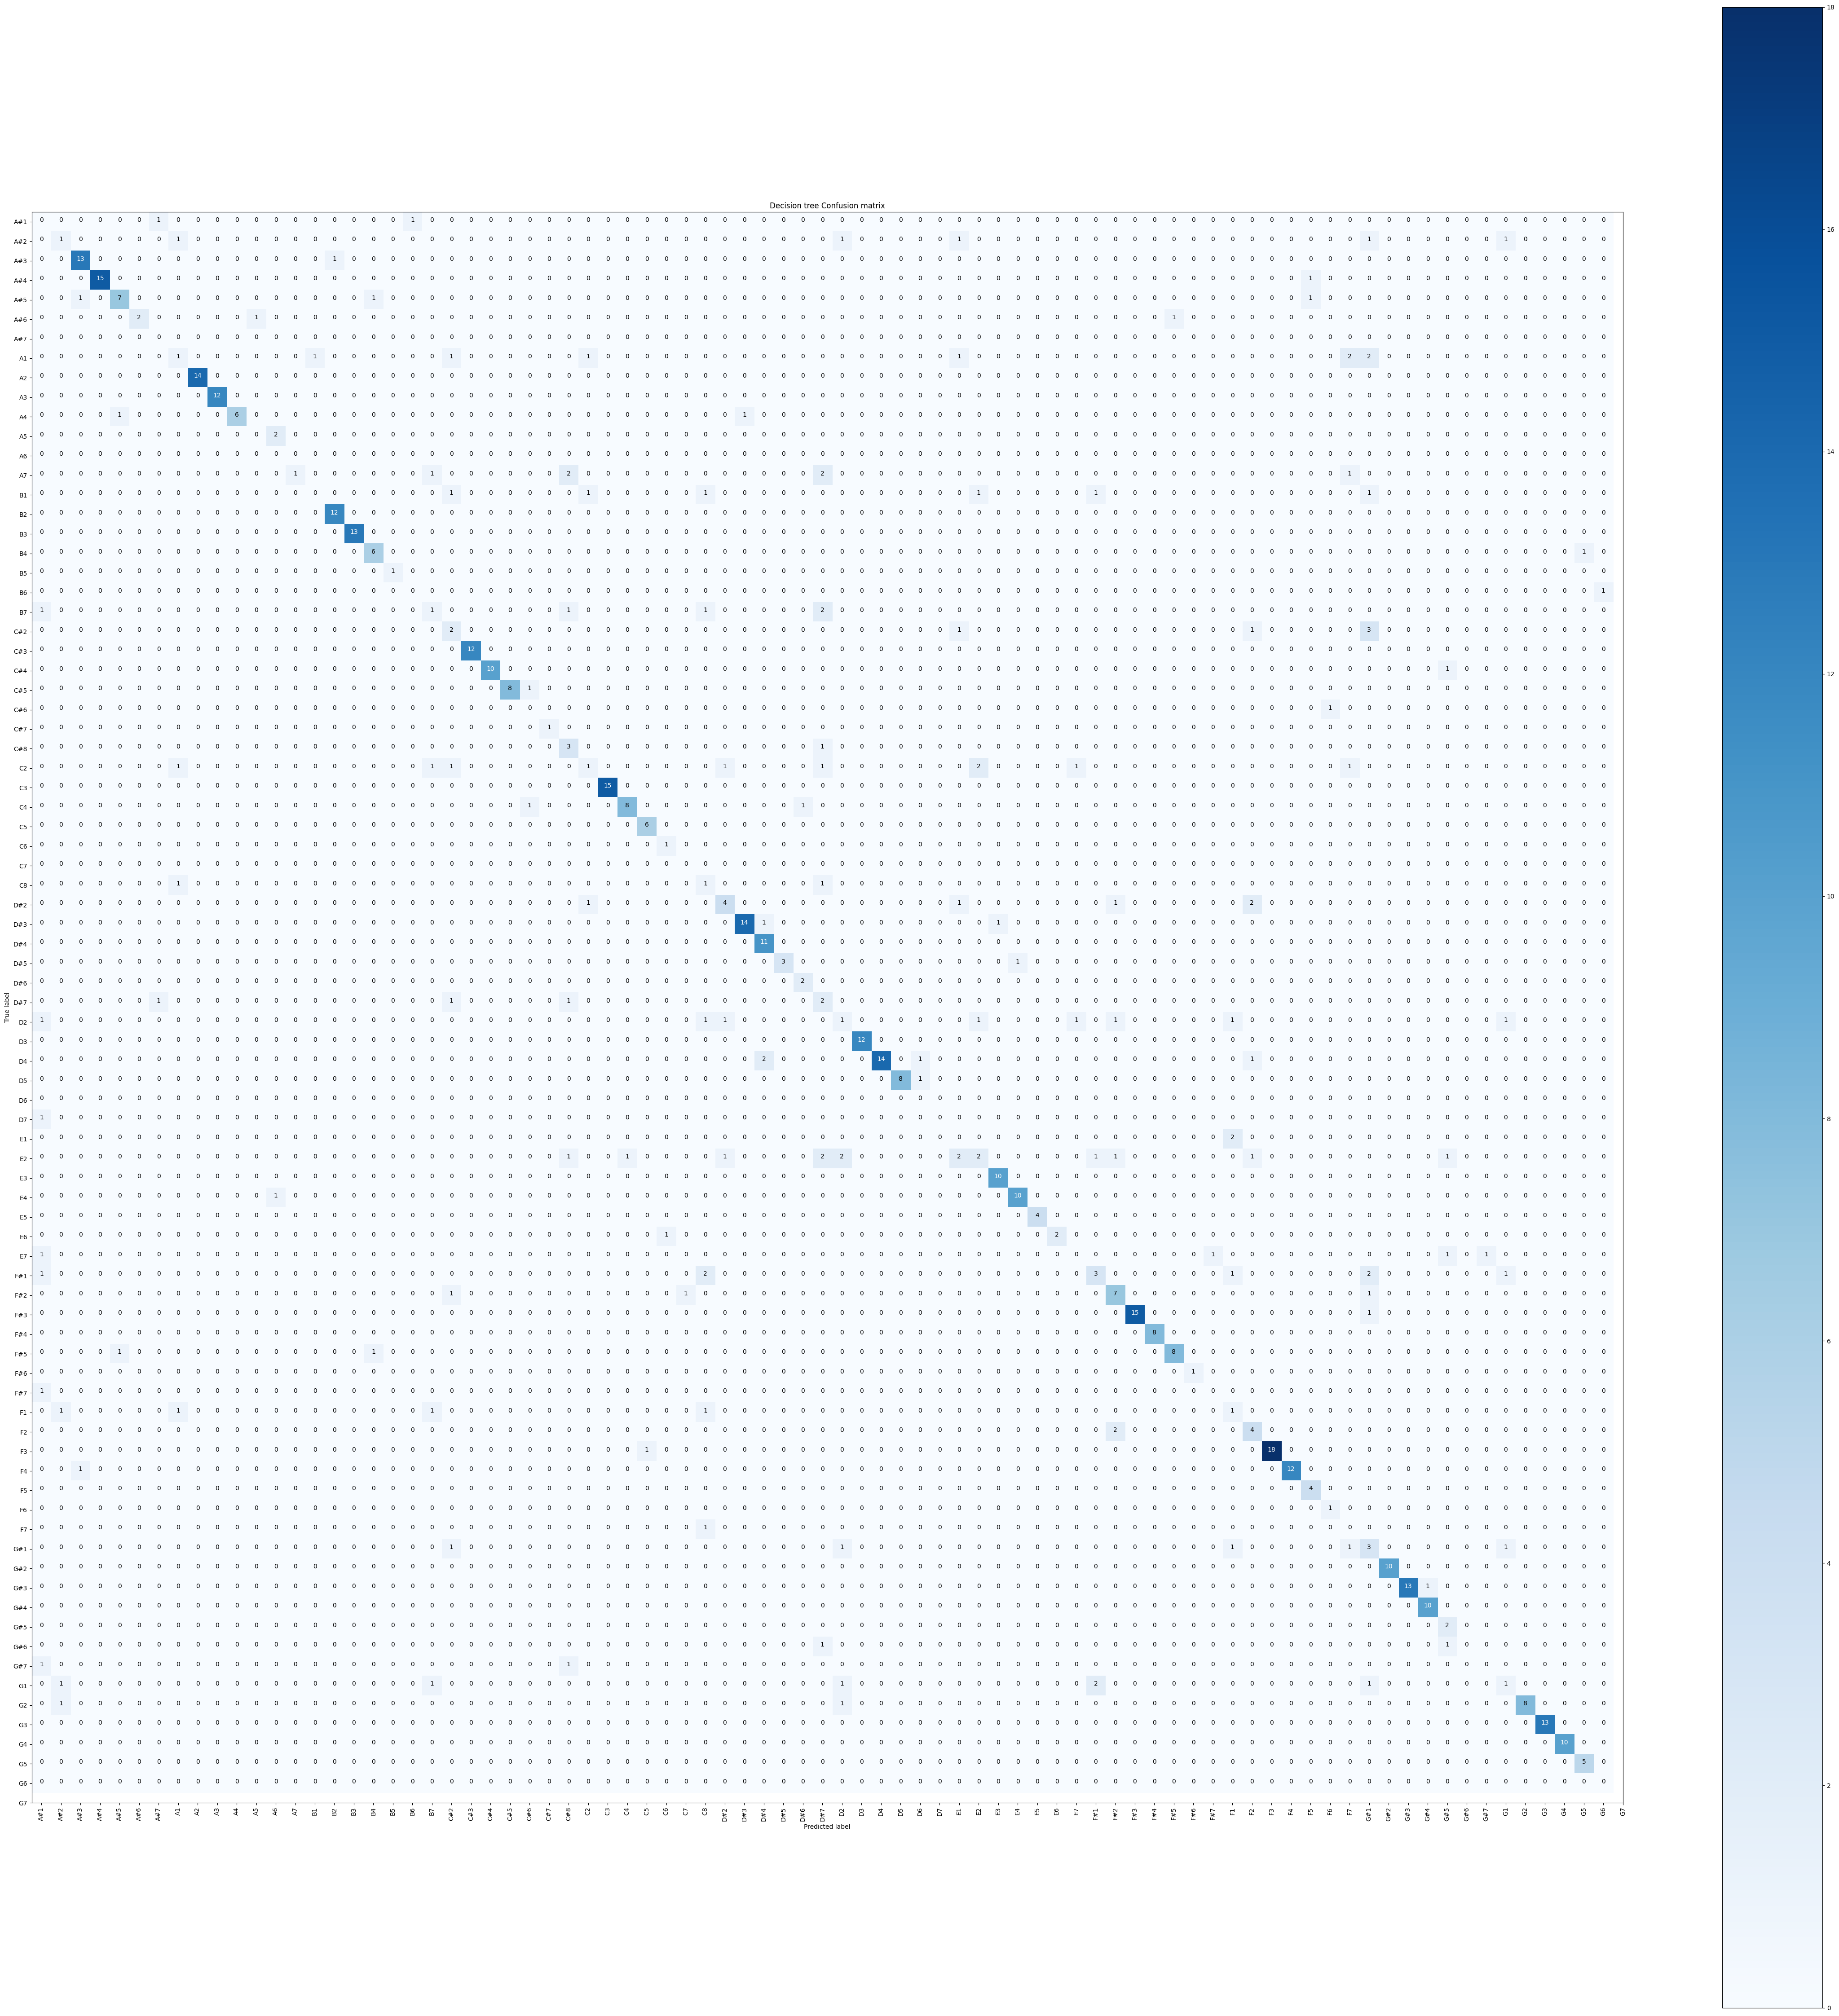

In [24]:
cm = confusion_matrix(y_test_pitch, y_pred_pitch)
plot_confusion_matrix(cm , pitch_classes, title="Decision tree Confusion matrix",figsize=(45,45))

4.
(c) MLP pitch classification performance:

1. MLP's validation scores are more consistent than those of the decision tree but slightly lower than those of the SVM, with values ranging from approximately 0.77 to 0.82.
2. The confusion matrix is similar to the SVM, the diagonal is quite dense, indicating a high number of correct classifications.

In [25]:
print("MLP train:")
# Create a model for pitch Classification
mlp_model_pitch = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
# Perform K-fold cross-validation
kfold = KFold(n_splits=6)
for train_index, val_index in kfold.split(X_train):
  # Get the train and validation subsets
  X_train_kfold, X_val_kfold = X_train[train_index], X_train[val_index]
  y_train_kfold_pitch, y_val_kfold_pitch = y_train_pitch[train_index], y_train_pitch[val_index]

  mlp_model_pitch.fit(X_train_kfold, y_train_kfold_pitch)

  print(" Validation score:", mlp_model_pitch.score(X_val_kfold,y_val_kfold_pitch))

print("Test score:", mlp_model_pitch.score(X_test,y_test_pitch))

MLP train:
 Validation score: 0.7737789203084833
 Validation score: 0.794344473007712
 Validation score: 0.7963917525773195
 Validation score: 0.8195876288659794
 Validation score: 0.7989690721649485
 Validation score: 0.8015463917525774
Test score: 0.8096054888507719


In [26]:
print("MLP evaluation:")
y_pred_pitch = mlp_model_pitch.predict(X_test)

accuracy = accuracy_score(y_test_pitch, y_pred_pitch)
recall = recall_score(y_test_pitch, y_pred_pitch, average='micro') #can try other ave method
precision = precision_score(y_test_pitch, y_pred_pitch, average='micro')

print('ACC = ',  round(accuracy,3))
print('precision = ', precision)
print('recall = ', recall)

MLP evaluation:
ACC =  0.81
precision =  0.8096054888507719
recall =  0.8096054888507719


Confusion matrix


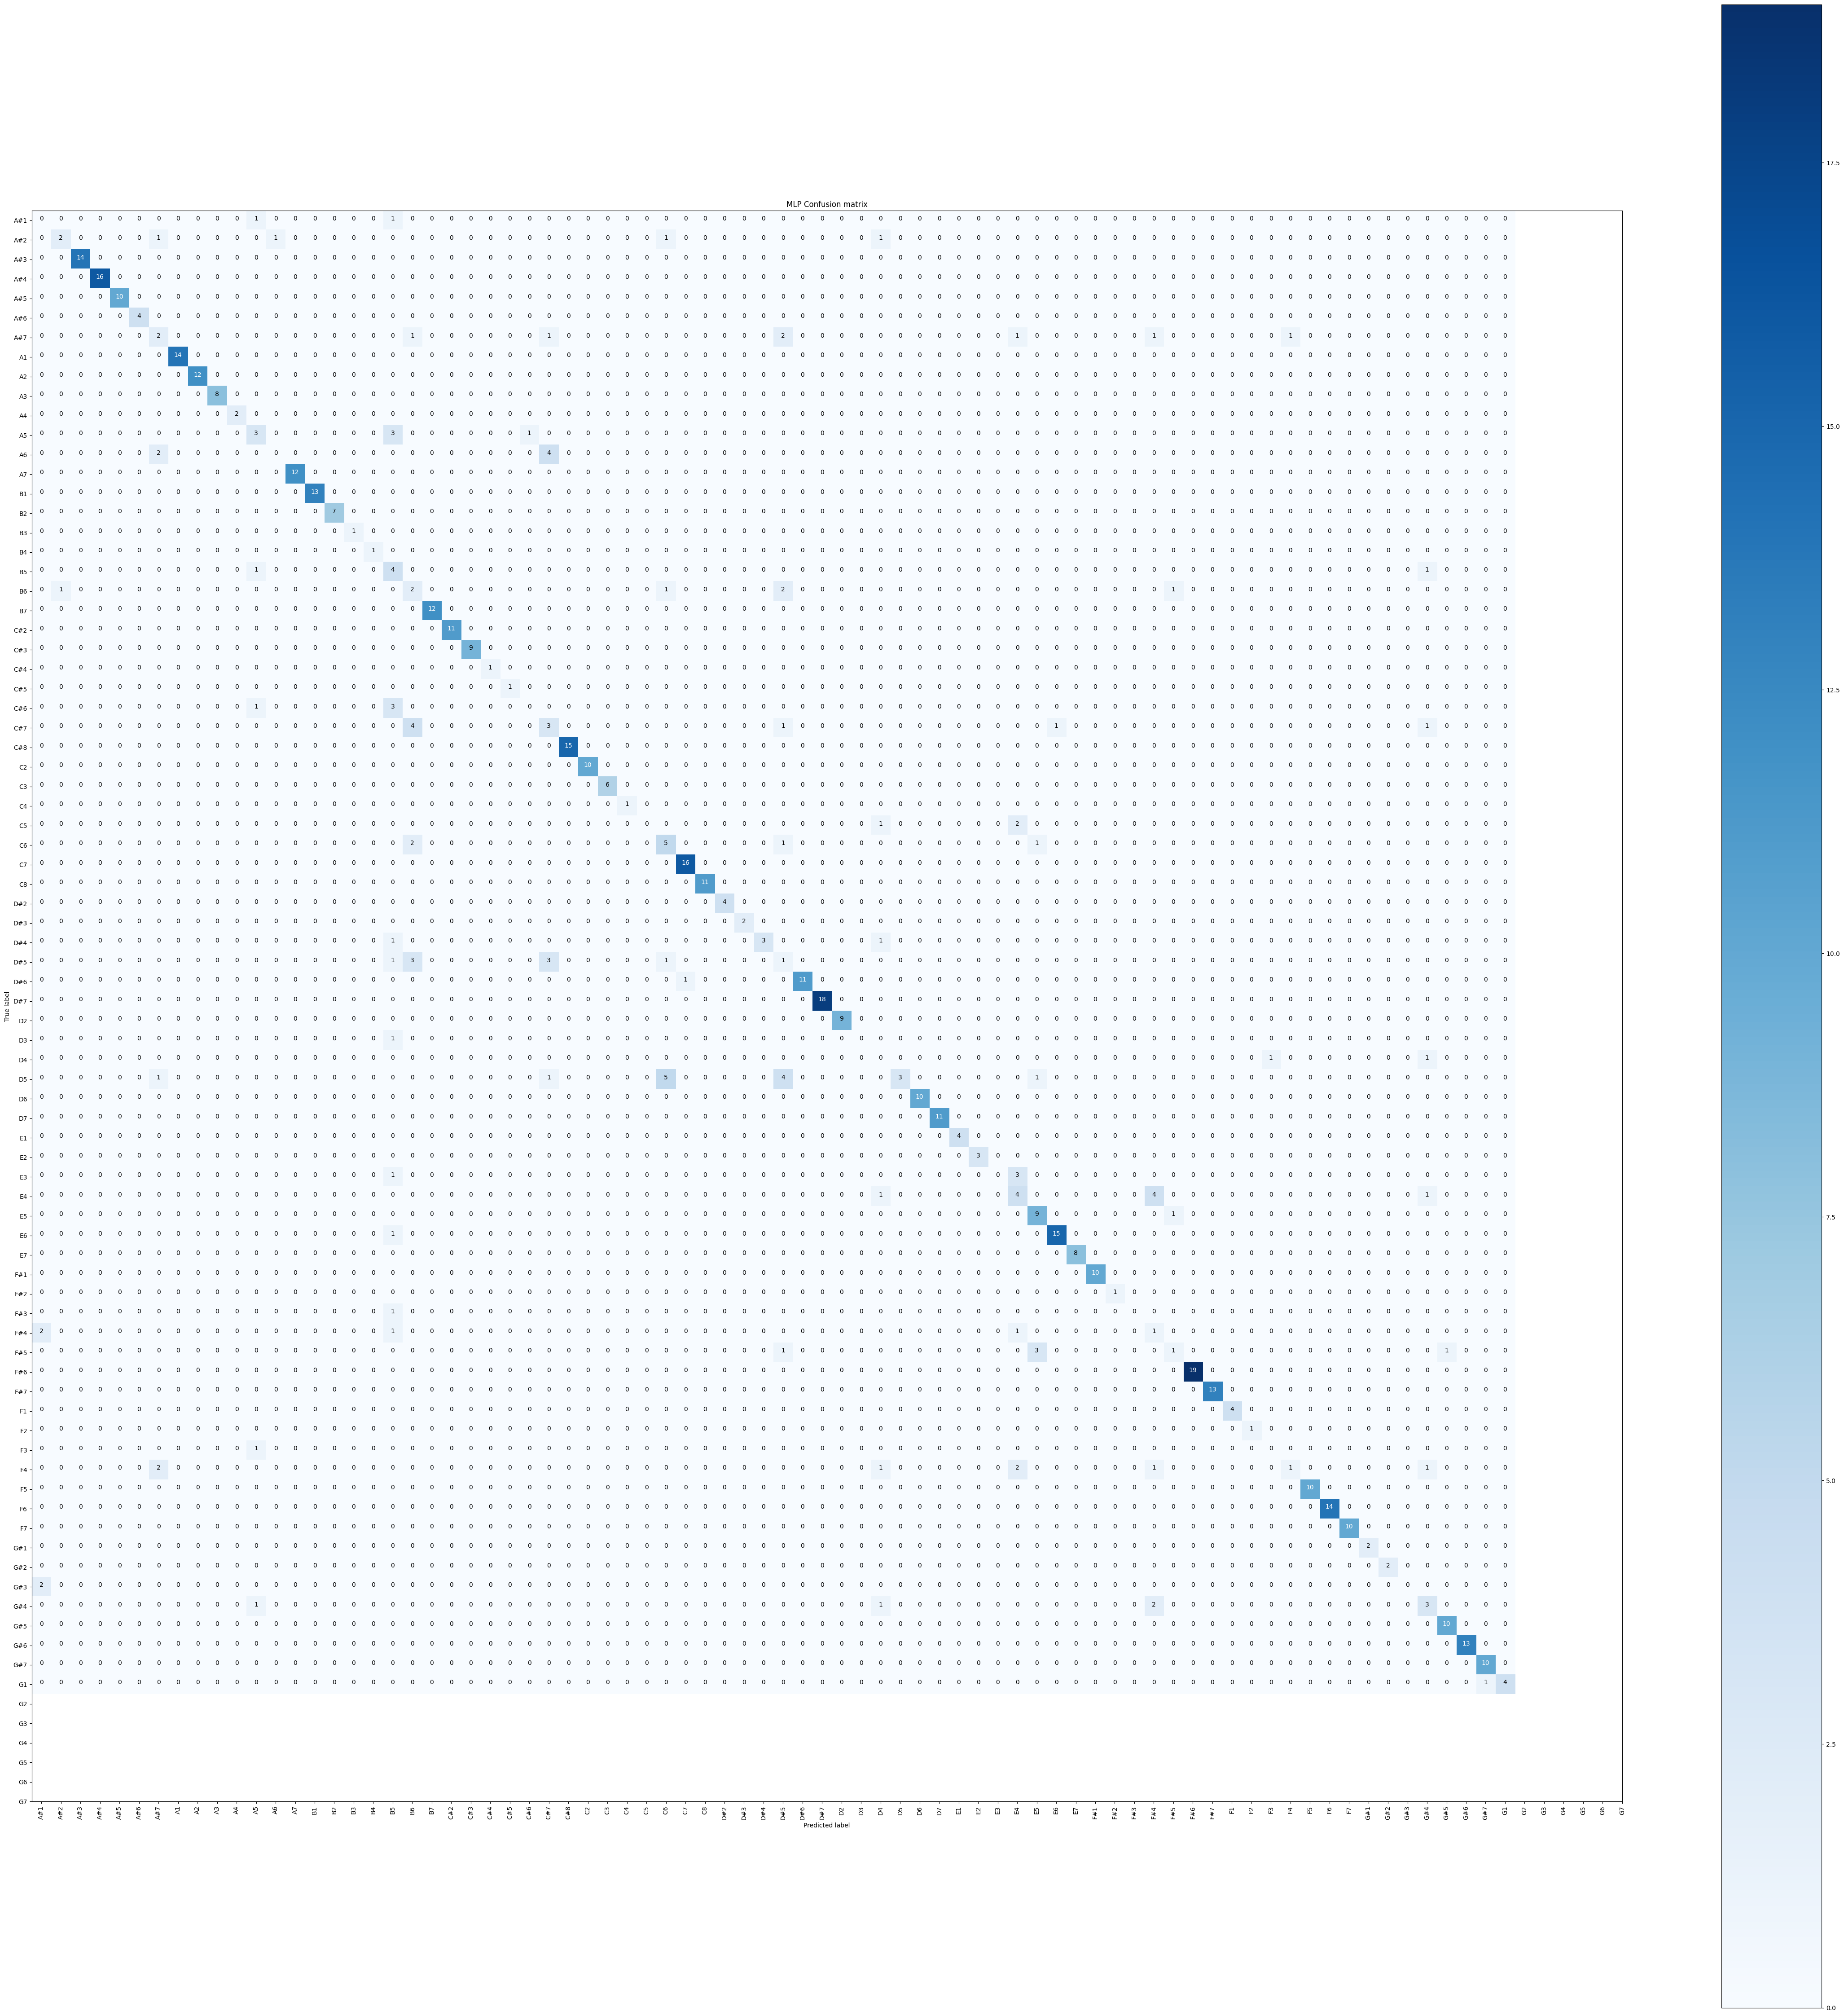

In [27]:
cm = confusion_matrix(y_test_pitch, y_pred_pitch)
plot_confusion_matrix(cm , pitch_classes, title="MLP Confusion matrix",figsize=(45,45))

5. Hyperparameters optimization

5.(a)  Tune the hyperparameters C and Gamma for SVM.

Test score with best parameters is : 0.8593481989708405, which is slightly better than the previous score: 0.8507718696397941. Note that I use linear SVM so the gamma parameter is not considered in this case.

Best params: {'C': 0.1}

A low C makes the decision surface smooth and simple, this can lead to a model that generalizes better to unseen data (better testing accuracy)

In [28]:
from sklearn.model_selection import GridSearchCV

print("SVM optimization:")
# Create a model for Pitch Classification
svm_model_pitch = SVC(kernel='linear', random_state=42)

# Define the parameter values that should be searched
C_range = [0.1, 1, 10, 100, 1000]

# Create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(C=C_range)

# Instantiate the grid with the model and the parameter grid
grid = GridSearchCV(svm_model_pitch, param_grid, cv=6, scoring='accuracy', verbose=2)

# Fit the grid with data - using the entire training set here
grid.fit(X_train, y_train_pitch)

# View the complete results (list of named tuples)
print("Grid results:", grid.cv_results_)

# Examine the best model
print("Best score:", grid.best_score_)
print("Best params:", grid.best_params_)

# Evaluate the best model found on the test set
print("Test score with best parameters:", grid.score(X_test, y_test_pitch))


SVM optimization:
Fitting 6 folds for each of 5 candidates, totalling 30 fits


/Users/yian/miniconda3/envs/env_py39/lib/python3.9/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=6.
  warnings.warn(


[CV] END ..............................................C=0.1; total time=   0.2s
[CV] END ..............................................C=0.1; total time=   0.2s
[CV] END ..............................................C=0.1; total time=   0.2s
[CV] END ..............................................C=0.1; total time=   0.2s
[CV] END ..............................................C=0.1; total time=   0.2s
[CV] END ..............................................C=0.1; total time=   0.2s
[CV] END ................................................C=1; total time=   0.2s
[CV] END ................................................C=1; total time=   0.2s
[CV] END ................................................C=1; total time=   0.2s
[CV] END ................................................C=1; total time=   0.2s
[CV] END ................................................C=1; total time=   0.2s
[CV] END ................................................C=1; total time=   0.2s
[CV] END ...................

5. 
(b) Tune hyperparameters Criterion and Maximum Depth of DecisionTree


Best params: {'criterion': 'entropy', 'max_depth': 15}

Test score with best parameters: 0.7495711835334476, which is better than the previous score: 0.7358490566037735. Besides, the Best training score: 0.7231722453378563 is also better than all theprevious training score.

It chooses the split which has the highest information gain, and a max_depth of 15 was found to be optimal in the best performance on this particular dataset.


In [29]:
from sklearn.model_selection import GridSearchCV

print("Decision tree optimization:")
# Create a model for Pitch Classification
dt_model_pitch = DecisionTreeClassifier(random_state=42)

# Define the parameter values that should be searched
criterion_range = ['gini', 'entropy']
max_depth_range = range(5, 20)  # You can set this range based on prior knowledge or exploratory analysis

# Create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(criterion=criterion_range, max_depth=max_depth_range)

# Instantiate the grid with the model and the parameter grid
grid = GridSearchCV(dt_model_pitch, param_grid, cv=6, scoring='accuracy', verbose=2)

# Fit the grid with data
grid.fit(X_train, y_train_pitch)

print("Grid results:", grid.cv_results_)

print("Best score:", grid.best_score_)
print("Best params:", grid.best_params_)

print("Test score with best parameters:", grid.score(X_test, y_test_pitch))


Decision tree optimization:
Fitting 6 folds for each of 30 candidates, totalling 180 fits
[CV] END ........................criterion=gini, max_depth=5; total time=   0.1s
[CV] END ........................criterion=gini, max_depth=5; total time=   0.1s
[CV] END ........................criterion=gini, max_depth=5; total time=   0.1s


/Users/yian/miniconda3/envs/env_py39/lib/python3.9/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=6.
  warnings.warn(


[CV] END ........................criterion=gini, max_depth=5; total time=   0.1s
[CV] END ........................criterion=gini, max_depth=5; total time=   0.1s
[CV] END ........................criterion=gini, max_depth=5; total time=   0.1s
[CV] END ........................criterion=gini, max_depth=6; total time=   0.1s
[CV] END ........................criterion=gini, max_depth=6; total time=   0.1s
[CV] END ........................criterion=gini, max_depth=6; total time=   0.1s
[CV] END ........................criterion=gini, max_depth=6; total time=   0.1s
[CV] END ........................criterion=gini, max_depth=6; total time=   0.1s
[CV] END ........................criterion=gini, max_depth=6; total time=   0.1s
[CV] END ........................criterion=gini, max_depth=7; total time=   0.1s
[CV] END ........................criterion=gini, max_depth=7; total time=   0.1s
[CV] END ........................criterion=gini, max_depth=7; total time=   0.1s
[CV] END ...................

5.(c) Tune the Hidden Layer Sizes and the strength of the L2 Regularization Term for MLP

 Test score with best parameters: 0.8353344768439108 is better than the previous Test score: 0.8096054888507719, with Best params: {'alpha': 0.1, 'hidden_layer_sizes': (100, 50)}.

 A larger alpha results in more regularization and a simpler, smoother model that's less likely to overfit. The best structure of layers and the number of nodes in each layer was found to be (100, 50), meaning two hidden layers, the first with 100 neurons and the second with 50 neurons.




In [30]:
from sklearn.model_selection import GridSearchCV

print("MLP optimization:")
mlp_model_pitch = MLPClassifier(max_iter=1000, random_state=42)

# For hidden_layer_sizes, tuples represent the layers and the number of neurons in each layer.
# For example, (50,) means 1 hidden layer with 50 neurons, and (50, 50) means 2 hidden layers, each with 50 neurons.
hidden_layer_sizes_range = [(50,), (100,), (50, 50), (100, 50)]
alpha_range = [0.0001, 0.001, 0.01, 0.1]

# Create a parameter grid: map the parameter names to the values that should be searched
param_grid = {
    'hidden_layer_sizes': hidden_layer_sizes_range,
    'alpha': alpha_range
}

# Instantiate the grid
grid = GridSearchCV(mlp_model_pitch, param_grid, cv=6, scoring='accuracy', verbose=2)

grid.fit(X_train, y_train_pitch)

print("Grid results:", grid.cv_results_)

print("Best score:", grid.best_score_)
print("Best params:", grid.best_params_)

print("Test score with best parameters:", grid.score(X_test, y_test_pitch))


MLP optimization:
Fitting 6 folds for each of 16 candidates, totalling 96 fits


/Users/yian/miniconda3/envs/env_py39/lib/python3.9/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=6.
  warnings.warn(


[CV] END .............alpha=0.0001, hidden_layer_sizes=(50,); total time=   1.1s
[CV] END .............alpha=0.0001, hidden_layer_sizes=(50,); total time=   2.7s
[CV] END .............alpha=0.0001, hidden_layer_sizes=(50,); total time=   1.5s
[CV] END .............alpha=0.0001, hidden_layer_sizes=(50,); total time=   1.5s
[CV] END .............alpha=0.0001, hidden_layer_sizes=(50,); total time=   2.1s
[CV] END .............alpha=0.0001, hidden_layer_sizes=(50,); total time=   1.1s
[CV] END ............alpha=0.0001, hidden_layer_sizes=(100,); total time=   1.2s
[CV] END ............alpha=0.0001, hidden_layer_sizes=(100,); total time=   1.9s
[CV] END ............alpha=0.0001, hidden_layer_sizes=(100,); total time=   1.9s
[CV] END ............alpha=0.0001, hidden_layer_sizes=(100,); total time=   3.0s
[CV] END ............alpha=0.0001, hidden_layer_sizes=(100,); total time=   2.2s
[CV] END ............alpha=0.0001, hidden_layer_sizes=(100,); total time=   0.7s
[CV] END ..........alpha=0.0